### Number of PhDs per institution
- using NSF PHD exit survey
- data is from 2013 to correspond to the faculty hiring dataset
- https://www.nsf.gov/statistics/sed/2013/data-tables.cfm

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from postdocsalary.paths import DATA_DIR, ensure_dir
import urllib.request
pd.set_option('display.max_columns', None)


In [14]:
survey_df = pd.read_csv(DATA_DIR/ 'nsf_survey'/ 'phds_2013_simplified.csv')
len(survey_df)

526

In [15]:
state_abb_df = pd.read_csv(DATA_DIR/ 'BEA_price_parity' / 'state_abb.csv')
state_abb_dict = {row.State:row.Abbreviation for idx, row in state_abb_df.iterrows()}
state_abb_dict["Puerto Rico"] = "PR"
state_abb_df[:3]

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ


In [16]:
def update_university_name(name, abbv, state):
    if type(name) is not str:
        return np.nan
    name = name.replace('U.', 'University')
    name = name.replace('C.', 'College')
    
    name = name.replace('University {}'.format(abbv), 'University of {}'.format(state))
    name = name.replace(' {}'.format(abbv), ' {}'.format(state))
    name = name.replace('{} '.format(abbv), '{} '.format(state))
        
    
    return name

In [17]:
state= None
state_next =False
name_list = []
for name in survey_df.Institution.values:
    if type(name) == float:
        state_next = True
        name_list.append(np.nan)
        continue
    if state_next:
        state = name
        state_next = False
        name_list.append(np.nan)
        continue
    if state == None:
        name_list.append(name)
        continue
    abbv = state_abb_dict[ state[:-1]]
    name = update_university_name(name, abbv,  state[:-1])
    name_list.append(name)
    #print(name)

In [18]:
survey_df

,Institution,number
0,All Institutions,"52,760"
1,NaN,NaN
2,Alabama,644
3,AL A&M U.,7
4,AL State U.,13
...,...,...
521,"U. WI, Madison",735
522,"U. WI, Milwaukee",152
523,NaN,NaN
524,Wyoming,66


In [19]:
survey_df['Institution'] = name_list

In [22]:
survey_df = survey_df[survey_df.Institution.isnull() == False]

In [27]:
def strip_name(name):
    return ''.join(filter( lambda x: x in '0123456789abcdefghijklmnopqrstuvwxyz', name.lower()))

In [29]:
survey_df['n_grads'] = survey_df['number'].apply(strip_name).astype(float)

<ipython-input-29-795d9a8ff820>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_df['n_grads'] = survey_df['number'].apply(strip_name).astype(float)


In [30]:
survey_df.sort_values(by='n_grads', ascending=False)

,Institution,number,n_grads
0,All Institutions,"52,760",52760.0
54,"University of California, Berkeley",911,911.0
239,"University of Michigan, Ann Arbor",853,853.0
473,"University of Texas, Austin",798,798.0
53,"Stanford University, Stanford",763,763.0
...,...,...,...
319,Juilliard School,1,1.0
377,"Oklahoma State University, Health Sciences Ctr.",1,1.0
240,"University of Michigan, Dearborn",1,1.0
128,Boise State University,1,1.0


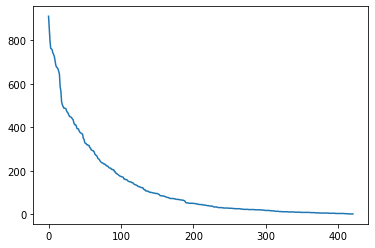

In [36]:
plt.plot(survey_df.sort_values(by='n_grads', ascending=False).n_grads.values[1:])

In [37]:
survey_df[['Institution', 'n_grads']].to_pickle(DATA_DIR/ 'nsf_survey'/ 'phds_2013_simplified_counts.csv')